In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from harp_resources import process, utils
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats

# Read extraced variables into csv

In [80]:
Vars = pd.read_csv('GCaAMP_MM_extracted_vars.csv')
Vars

FileNotFoundError: [Errno 2] No such file or directory: 'GCaAMP_MM_extracted_vars.csv'

# Make boxplots to view difference in params for halts and no-halts 

In [77]:
halt_data = Vars.loc[Vars.event == 'halt']
halt_data.describe() 

,EventTime,moveX,moveY,PeakResponse,MinResponse,MeanResponse,MeanResponse_after,MinResponse_after,PeakResponse_after
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,270.000000,270.000000,270.000000
mean,871.071727,0.084850,0.008276,1.803608,-1.271660,0.274154,-0.092315,-1.507631,1.451659
std,504.796850,0.055301,0.037692,1.857066,1.399828,1.563949,1.580134,1.590837,1.903358
min,33.536000,-0.008731,-0.552882,-1.873555,-6.926169,-4.914830,-6.643711,-8.288395,-4.114350
25%,467.905000,0.040081,0.003619,0.458492,-1.895109,-0.617351,-0.856918,-2.328360,0.271571
50%,806.201000,0.092897,0.009088,1.538788,-1.115418,0.125052,-0.051599,-1.305856,1.218381
75%,1350.945000,0.118860,0.014251,2.672760,-0.301219,1.122763,0.710005,-0.523620,2.508123
max,1908.957000,0.238479,0.239590,10.529824,3.407252,7.155295,4.872742,3.926176,9.405889


In [78]:
Nohalt_data = Vars.loc[Vars.event == 'No_halt']
Nohalt_data.describe() 

,EventTime,moveX,moveY,PeakResponse,MinResponse,MeanResponse,MeanResponse_after,MinResponse_after,PeakResponse_after
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


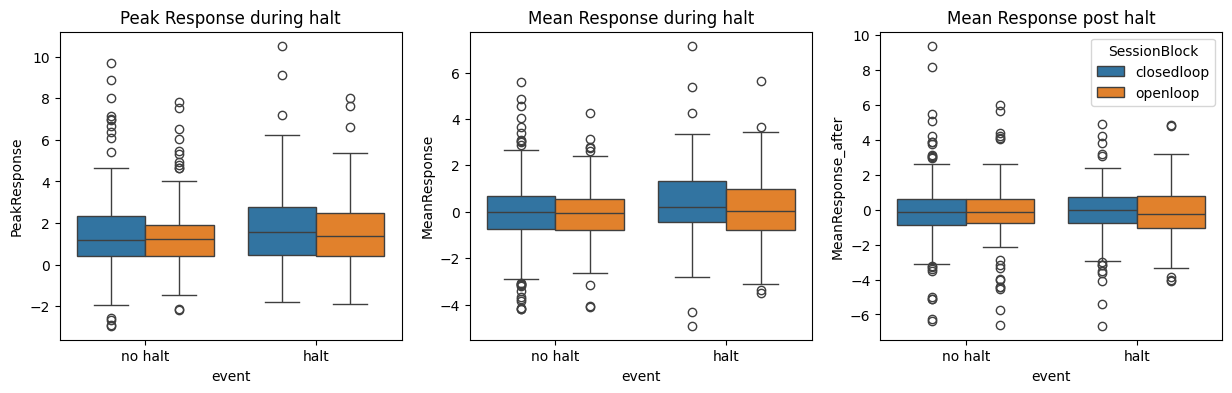

In [55]:
fig, ax = plt.subplots(1,3, figsize = (15, 4))

sns.boxplot(x="event", y="PeakResponse", data=Vars, hue="SessionBlock", ax=ax[0])
ax[0].set_title("Peak Response during halt")
ax[0].get_legend().remove()

sns.boxplot(x="event", y="MeanResponse", data=Vars, hue="SessionBlock", ax=ax[1])
ax[1].set_title("Mean Response during halt")
ax[1].get_legend().remove()

sns.boxplot(x="event", y="MeanResponse_after", data=Vars, hue="SessionBlock", ax=ax[2])
ax[2].set_title("Mean Response post halt")


plt.show()


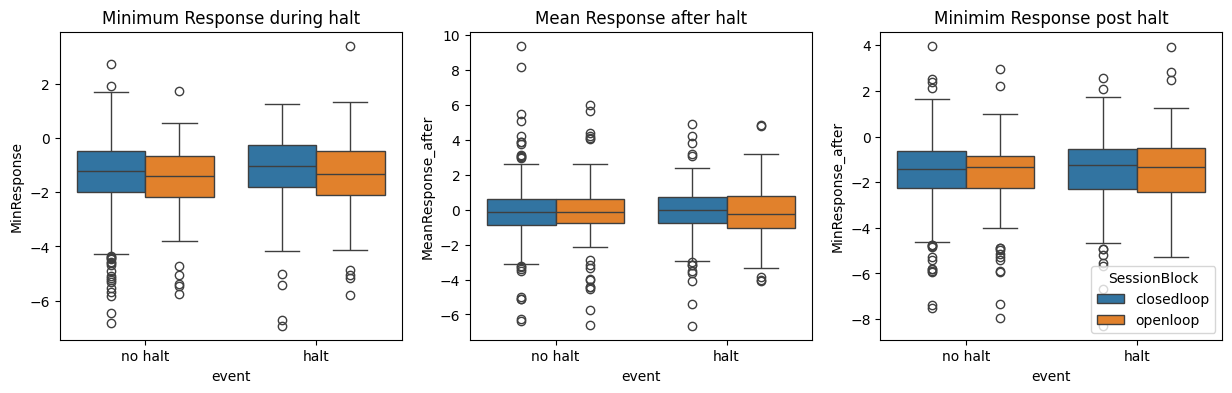

In [64]:
fig, ax = plt.subplots(1,3, figsize = (15, 4))

sns.boxplot(x="event", y="MinResponse", data=Vars, hue="SessionBlock", ax=ax[0])
ax[0].set_title("Minimum Response during halt")
ax[0].get_legend().remove()

sns.boxplot(x="event", y="MeanResponse_after", data=Vars, hue="SessionBlock", ax=ax[1])
ax[1].set_title("Mean Response after halt")
ax[1].get_legend().remove()

sns.boxplot(x="event", y="MinResponse_after", data=Vars, hue="SessionBlock", ax=ax[2])
ax[2].set_title("Minimim Response post halt")


plt.show()

In [66]:
#Fit a variable at a time
response_running = smf.ols('PeakResponse ~ moveX', data=Vars).fit()

print(response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

                            OLS Regression Results                            
Dep. Variable:           PeakResponse   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.029
Date:                Wed, 11 Dec 2024   Prob (F-statistic):              0.155
Time:                        16:11:42   Log-Likelihood:                -1416.0
No. Observations:                 709   AIC:                             2836.
Df Residuals:                     707   BIC:                             2845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7222      0.124     13.907      0.0

Text(0, 0.5, 'Actual PeakResponse')

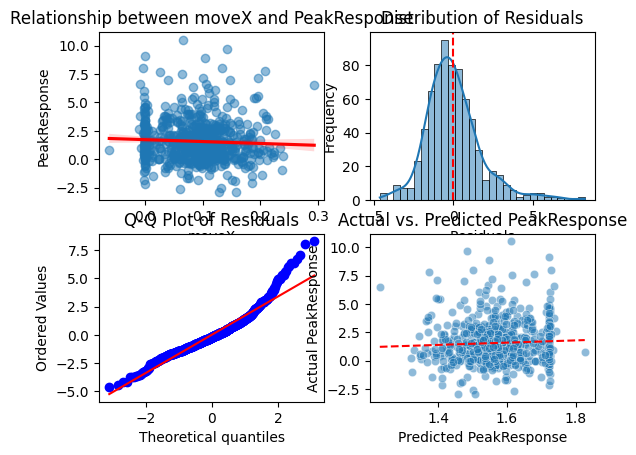

In [74]:
# Scatterplot with regression line
fig, ax =  plt.subplots(2,2)
ax = ax.flatten()
sns.regplot(
    x="moveX",
    y="PeakResponse",
    data=Vars,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.5}, ax= ax[0]
)
ax[0].set_title("Relationship between moveX and PeakResponse")
ax[0].set_xlabel("moveX")
ax[0].set_ylabel("PeakResponse")

sns.histplot(residuals, kde=True, bins=30, ax = ax[1])
ax[1].set_title("Distribution of Residuals")
ax[1].set_xlabel("Residuals")
ax[1].set_ylabel("Frequency")
ax[1].axvline(0, color='red', linestyle='--')

# Q-Q plot

stats.probplot(residuals, dist="norm", plot= ax[2])
ax[2].set_title("Q-Q Plot of Residuals")


predicted = 1.7222 + (-1.6735 * Vars["moveX"])

# Actual vs. predicted plot
sns.scatterplot(x=predicted, y=Vars["PeakResponse"], alpha=0.5, ax = ax[3])
ax[3].plot([min(predicted), max(predicted)], [min(predicted), max(predicted)], color="red", linestyle="--")
ax[3].set_title("Actual vs. Predicted PeakResponse")
ax[3].set_xlabel("Predicted PeakResponse")
ax[3].set_ylabel("Actual PeakResponse")



In [51]:
# Fit a mixed-effects model
mixed_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",  # Fixed effects
    data=Vars,
    groups=Vars["MouseID"],  # Random intercept for MouseID
).fit()

print(mixed_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    PeakResponse
No. Observations:      709        Method:                REML        
No. Groups:            5          Scale:                 3.0551      
Min. group size:       123        Log-Likelihood:        -1408.9420  
Max. group size:       160        Converged:             Yes         
Mean group size:       141.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.784    0.213  8.373 0.000  1.367  2.202
event[T.no halt]           -0.398    0.136 -2.925 0.003 -0.665 -0.131
SessionNumber[T.session 2]  0.130    0.133  0.974 0.330 -0.131  0.390
SessionBlock[T.openloop]   -0.099    0.141 -0.702 0.482 -0.376  0.178
Group Var                   0.137   

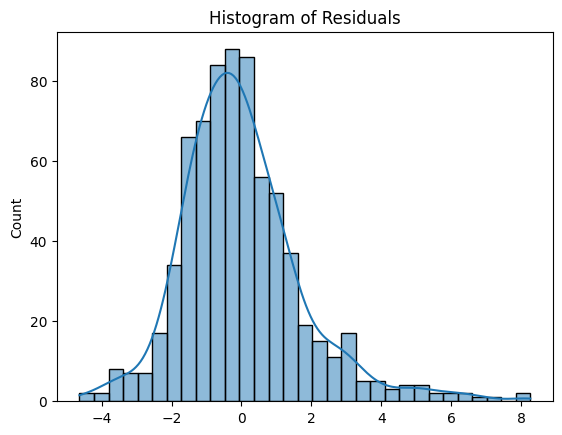

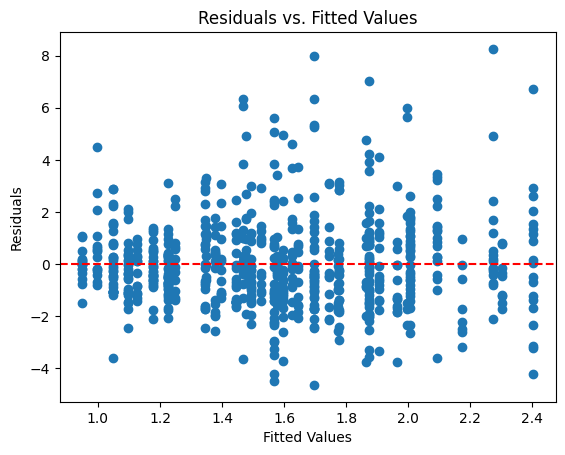

In [52]:

# Extract residuals
residuals = mixed_model.resid

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Residuals vs. fitted values
fitted_values = mixed_model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()